In [9]:
import numpy as np
import pickle
import os
import json
from scipy.stats import mode
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np

model_path = os.path.join(os.getcwd(), 'model_xgb.pkl')
data_partition_path = '/media/iittp/new volume'

testing_set = 'training'
feature_types = 'glcm_vege'  #either glcm or glcm_vege

if testing_set == 'training':
    dataset_tiles_dir = 'multispectral_tiles'
    data_json_path = os.path.join(data_partition_path, dataset_tiles_dir, 'data.json')

    if feature_types == 'glcm':
        features_dir = os.path.join(os.getcwd(), 'mutispectral_glcm_features')
    else:
        features_dir = os.path.join(os.getcwd(), 'multispectral_glcm_vege_features')

elif testing_set == 'validation':
    dataset_tiles_dir = 'multispectral_validation_tiles'
    data_json_path = os.path.join(data_partition_path, dataset_tiles_dir, 'data.json')

    features_dir = os.path.join(os.getcwd(), f'multispectral_validation_{feature_types}_features')

with open(model_path, 'rb') as f:
    model = pickle.load(f)

with open(data_json_path) as f:
    data_json = json.load(f)

classes = list(data_json.keys())
classes_id = {cls:i for i,cls in enumerate(classes)}
print("\n".join([f"ID: {i}, CLASS: {cls}" for i, cls in enumerate(classes)]))

ID: 0, CLASS: banana
ID: 1, CLASS: elephant_foot
ID: 2, CLASS: paddy
ID: 3, CLASS: turmeric


In [10]:
images = {}
image_features = {}
for cls in classes:
    images[cls] = {}
    cls_features = np.load(os.path.join(features_dir, f"{cls}.npz"))['features']
    image_features[cls] = cls_features
    print(f"Loaded {cls_features.shape} from class {cls}")

    for i, fname in enumerate(data_json[cls]):
        fname_base = fname.rsplit('_', 1)[0]

        if fname_base not in images[cls]:
            images[cls][fname_base] = []

        images[cls][fname_base].append(cls_features[i])
    
    for fname in images[cls]:
        images[cls][fname] = np.array(images[cls][fname])

features = []
labels = []
for cls in classes:
    class_features = image_features[cls]
    num_samples = class_features.shape[0]
    features.append(class_features)
    labels.extend([cls] * num_samples)

Loaded (444, 146) from class banana
Loaded (552, 146) from class elephant_foot
Loaded (612, 146) from class paddy
Loaded (444, 146) from class turmeric


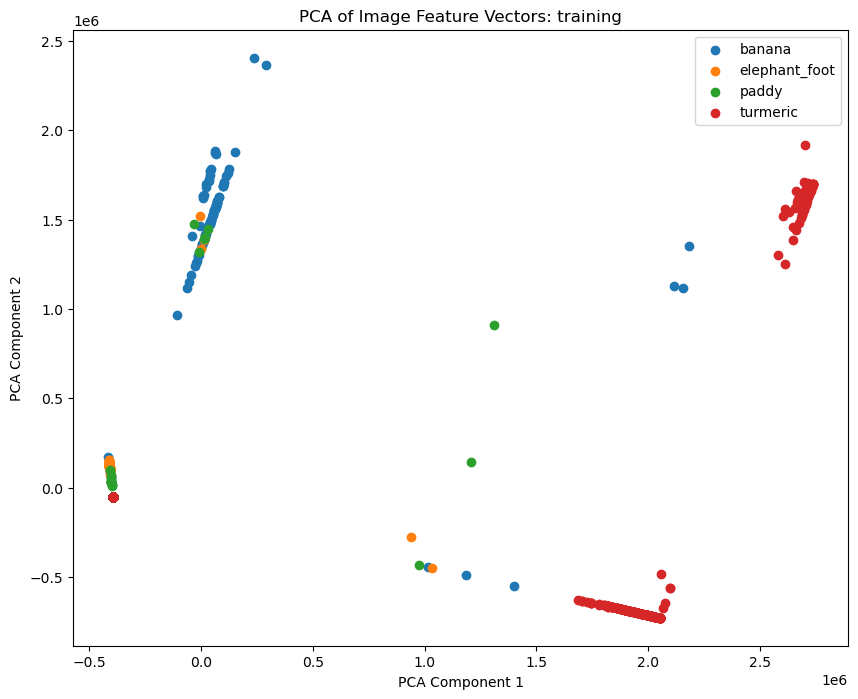

In [11]:
# Stack all feature vectors into one matrix
features_pca = np.vstack(features)

# Perform PCA for dimensionality reduction (2D for visualization)
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(features_pca)

# Plotting the results
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    class_indices = np.where(np.array(labels) == cls)[0]
    plt.scatter(reduced_features_pca[class_indices, 0], reduced_features_pca[class_indices, 1], label=cls)

plt.title(f'PCA of Image Feature Vectors: {testing_set}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='best')
plt.savefig(f"PCA_{testing_set}.jpg")
plt.show()

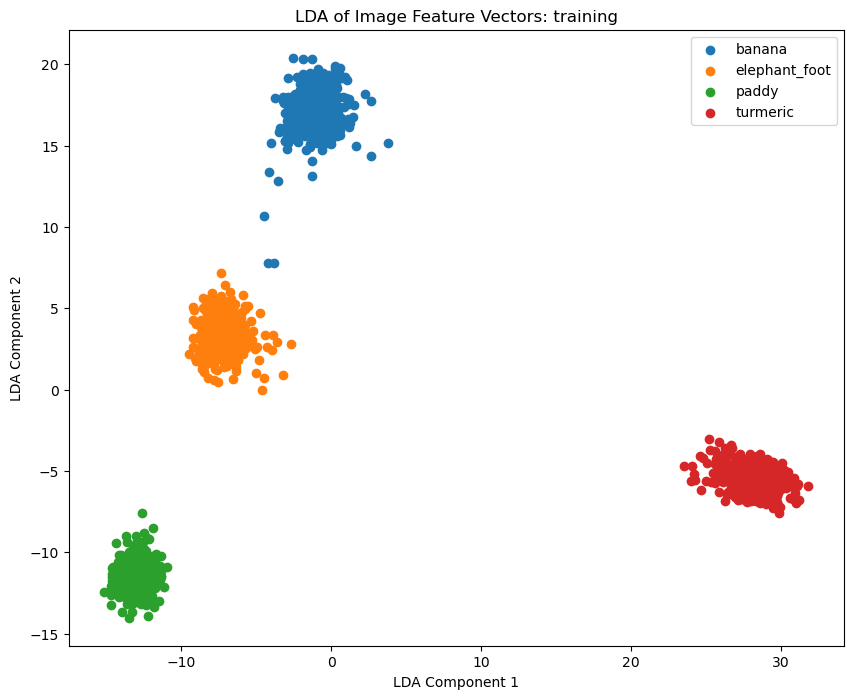

In [12]:
# Prepare your features and labels for LDA
features_lda = np.vstack([image_features[cls] for cls in classes])
labels_lda = np.concatenate([np.full(image_features[cls].shape[0], cls) for cls in classes])

# Perform LDA for dimensionality reduction
lda = LDA(n_components=2)  # We reduce to 2 dimensions for visualization
lda_result = lda.fit_transform(features_lda, labels_lda)

# Plotting the results
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    class_indices = np.where(labels_lda == cls)[0]
    plt.scatter(lda_result[class_indices, 0], lda_result[class_indices, 1], label=cls)

plt.title(f'LDA of Image Feature Vectors: {testing_set}')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend(loc='best')
plt.savefig(f"LDA_{testing_set}.jpg")
plt.show()